# Power Analysis for Alpha Diversity Differences in Crohn's Disease Microbiome Studies

Evident is a Python-based software package designed specifically for power analysis and sample size calculation in microbiome research.

Although the original preprint and the introductory tutorial in the GitHub repository provide valuable background, this article focuses on a practical use case adapted from the developers’ example. The goal is to offer clearer, more accessible documentation by walking through the analysis step by step and explicitly mapping each code snippet to its corresponding stage in the analytical workflow.

The adapted use case demonstrates how to perform power analysis using Evident, with a focus on alpha diversity metrics in microbiome data. Along the way, it highlights the core functionality of the package and illustrates how Evident can be applied in a real-world microbiome study setting.

## Step 1: Define the reseach question

This analysis aims to estimate the statistical power required to detect differences in gut microbiome alpha diversity between Crohn’s disease phenotypes.

Specifically, we compare Faith’s Phylogenetic Diversity (Faith’s PD) between patients with B1 (non-penetrating) and non-B1 (penetrating or stricturing) disease behavior.

Understanding the required sample size for detecting meaningful differences in microbial diversity is critical for study planning, particularly in microbiome research where cohorts are often limited.

## Step 2: Choose the primary outcome

The primary outcome is Faith’s Phylogenetic Diversity (Faith’s PD), a continuous alpha diversity metric that incorporates phylogenetic relationships among taxa.

Because Faith’s PD reflects both richness and evolutionary diversity, it is commonly used in gut microbiome studies and is appropriate for parametric comparison when distributional assumptions are met.

## Step 3: Specify the statistics test

To compare mean alpha diversity between two independent groups (B1 vs non-B1), we use a two-sample t-test, assuming approximate normality of the outcome variable.

This test choice determines the effect size metric and power calculation framework used in later steps.

## Step 4: Specify effect size

Effect size is quantified using Cohen’s d, which measures the standardized difference in means between two groups.

In microbiome research, even modest effect sizes (e.g., d ≈ 0.3–0.5) may be biologically meaningful due to high inter-individual variability.

## Step 5: Specify design parameters

The following design parameters are specified for the power analysis:
- Significance level (α): 0.01, 0.05, and 0.10
- Target power: typically ≥ 0.80
- Two-sided hypothesis test
- No correction for multiple testing (single primary outcome)

## Step 6: Perform the power analysis

### 6.1 Install and import required packages

We use the evident Python package, which provides tools for power analysis tailored to microbiome and ecological data.

Additional libraries are used for data manipulation and visualization.

In [54]:
import evident 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from evident.plotting import plot_power_curve

### 6.2 Load metadata and alpha diversity values

The dataset is loaded directly from the evident GitHub repository.

In [55]:
# URL to the metadata file in the evident GitHub repository
metadata_url = "https://raw.githubusercontent.com/biocore/evident/9538cc2b6d736dfb2b0a6db5e2cac00be701dda0/evident/tests/data/metadata.tsv" # Raw equivalent URL

# Read the metadata file
metadata = pd.read_table(metadata_url, sep="\t", index_col=0)

# Display top rows of the metadata
print(metadata.head()) 


                   bmi  body_habitat  body_product     body_site calprotectin  \
1629.SubjectIBD001  25  UBERON:feces  UBERON:feces  UBERON:feces         63.0   
1629.SubjectIBD002  25  UBERON:feces  UBERON:feces  UBERON:feces        212.0   
1629.SubjectIBD003  25  UBERON:feces  UBERON:feces  UBERON:feces        258.0   
1629.SubjectIBD004  25  UBERON:feces  UBERON:feces  UBERON:feces        499.0   
1629.SubjectIBD005  25  UBERON:feces  UBERON:feces  UBERON:feces        104.0   

                                              cd_behavior   cd_location  \
1629.SubjectIBD001  Non-stricturing, non-penetrating (B1)  Colonic (L2)   
1629.SubjectIBD002  Non-stricturing, non-penetrating (B1)  Colonic (L2)   
1629.SubjectIBD003  Non-stricturing, non-penetrating (B1)  Colonic (L2)   
1629.SubjectIBD004  Non-stricturing, non-penetrating (B1)  Colonic (L2)   
1629.SubjectIBD005  Non-stricturing, non-penetrating (B1)  Colonic (L2)   

                   cd_resection collection_timestamp    descri

The metadata table contains Faith’s PD values for 220 individuals, along with clinical and demographic variables such as disease behavior classification and sampling time points.

### 6.3 Subset Faith's PD and assess distribution

We extract Faith’s PD as the outcome variable and examine its summary statistics.

Assessing distributional properties helps evaluate whether the normality assumption required for a t-test is reasonable.

In [56]:
faith_pd = metadata["faith_pd"]

faith_pd.describe()

count    220.000000
mean      11.472170
std        4.144242
min        3.652244
25%        7.793526
50%       11.341452
75%       14.304098
max       22.203336
Name: faith_pd, dtype: float64

The mean and median are similar, with no extreme skewness, suggesting approximate normality.

A histogram with kernel density estimation (KDE) is plotted to visually assess the distribution of Faith’s PD values.

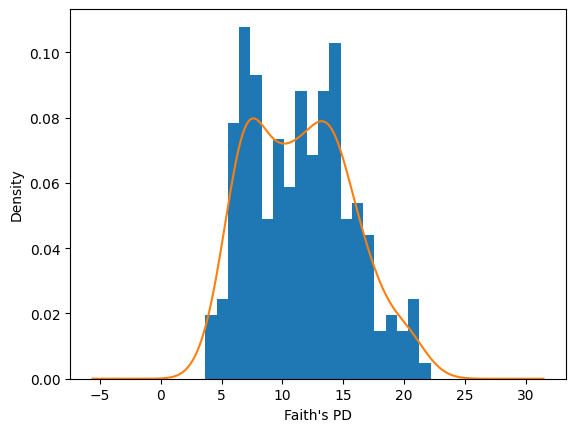

In [58]:
# Draw histrogram of faith_pd with kernal density estimate (KDE)
plt.hist(faith_pd, bins=20, density=True)
faith_pd.plot(kind='kde')
plt.xlabel("Faith's PD")
plt.ylabel("Density")
plt.show()

The KDE curve shows a roughly symmetric distribution centered around 10–12, supporting the use of parametric methods.

### 6.4 Create a UnivariateDataHandler object

The UnivariateDataHandler object stores the outcome variable and metadata, enabling effect size calculation and power simulations within the evident framework.

In [ ]:
adh = evident.UnivariateDataHandler(faith_pd, metadata)

### 6.5 Compare group-level summary statistics

We summarize Faith’s PD by disease behavior group to quantify observed differences between B1 and non-B1 patients.

In [9]:
metadata.groupby('classification')["faith_pd"].agg(["count", "mean", "std"]).round(2)

,count,mean,std
classification,,,
B1,99,13.57,3.46
Non-B1,121,9.76,3.87


Mean Faith’s PD is higher in the B1 group than in the non-B1 group, indicating a potentially meaningful difference.

### 6.6 Calculate effect size (Cohen's d)

Cohen’s d is calculated based on the observed group differences and pooled variability.

In [33]:
print(f"The effect size is: {adh.calculate_effect_size(column='classification').effect_size}")

The effect size is: 1.0311033633149984


The estimated effect size (~1.03) is considered large, suggesting strong separation between groups in this dataset.

### 6.7 Perform power analysis across sample sizes and alpha level

Power is simulated across a range of total sample sizes (10–100) and significance thresholds to evaluate study design trade-offs.

In [ ]:
# Define alpha levels and observation counts for power analysis
alpha_vals = [0.01, 0.05, 0.1]
obs_vals = np.arange(10, 101, step=10)  # 10 to 100 observations

# Perform power analysis
results = adh.power_analysis(
    "classification",
    alpha=alpha_vals,
    total_observations=obs_vals
)

### 6.8 Examine tabular results

In [41]:
# Tranform results to a DataFrame for easier viewing
df_results = results.to_dataframe()

print(df_results.head())

   alpha  total_observations     power  effect_size difference    metric  \
0   0.01                  10  0.104221     1.031103       None  cohens_d   
1   0.05                  10  0.301049     1.031103       None  cohens_d   
2   0.10                  10  0.439851     1.031103       None  cohens_d   
3   0.01                  20  0.315771     1.031103       None  cohens_d   
4   0.05                  20  0.587731     1.031103       None  cohens_d   

           column  
0  classification  
1  classification  
2  classification  
3  classification  
4  classification  


For example, with α = 0.05 and a total sample size of 10, power is approximately 0.30, indicating insufficient sensitivity at small sample sizes.

#### 6.9 Plot power curves

Power curves visualize how statistical power increases with sample size under different significance thresholds.

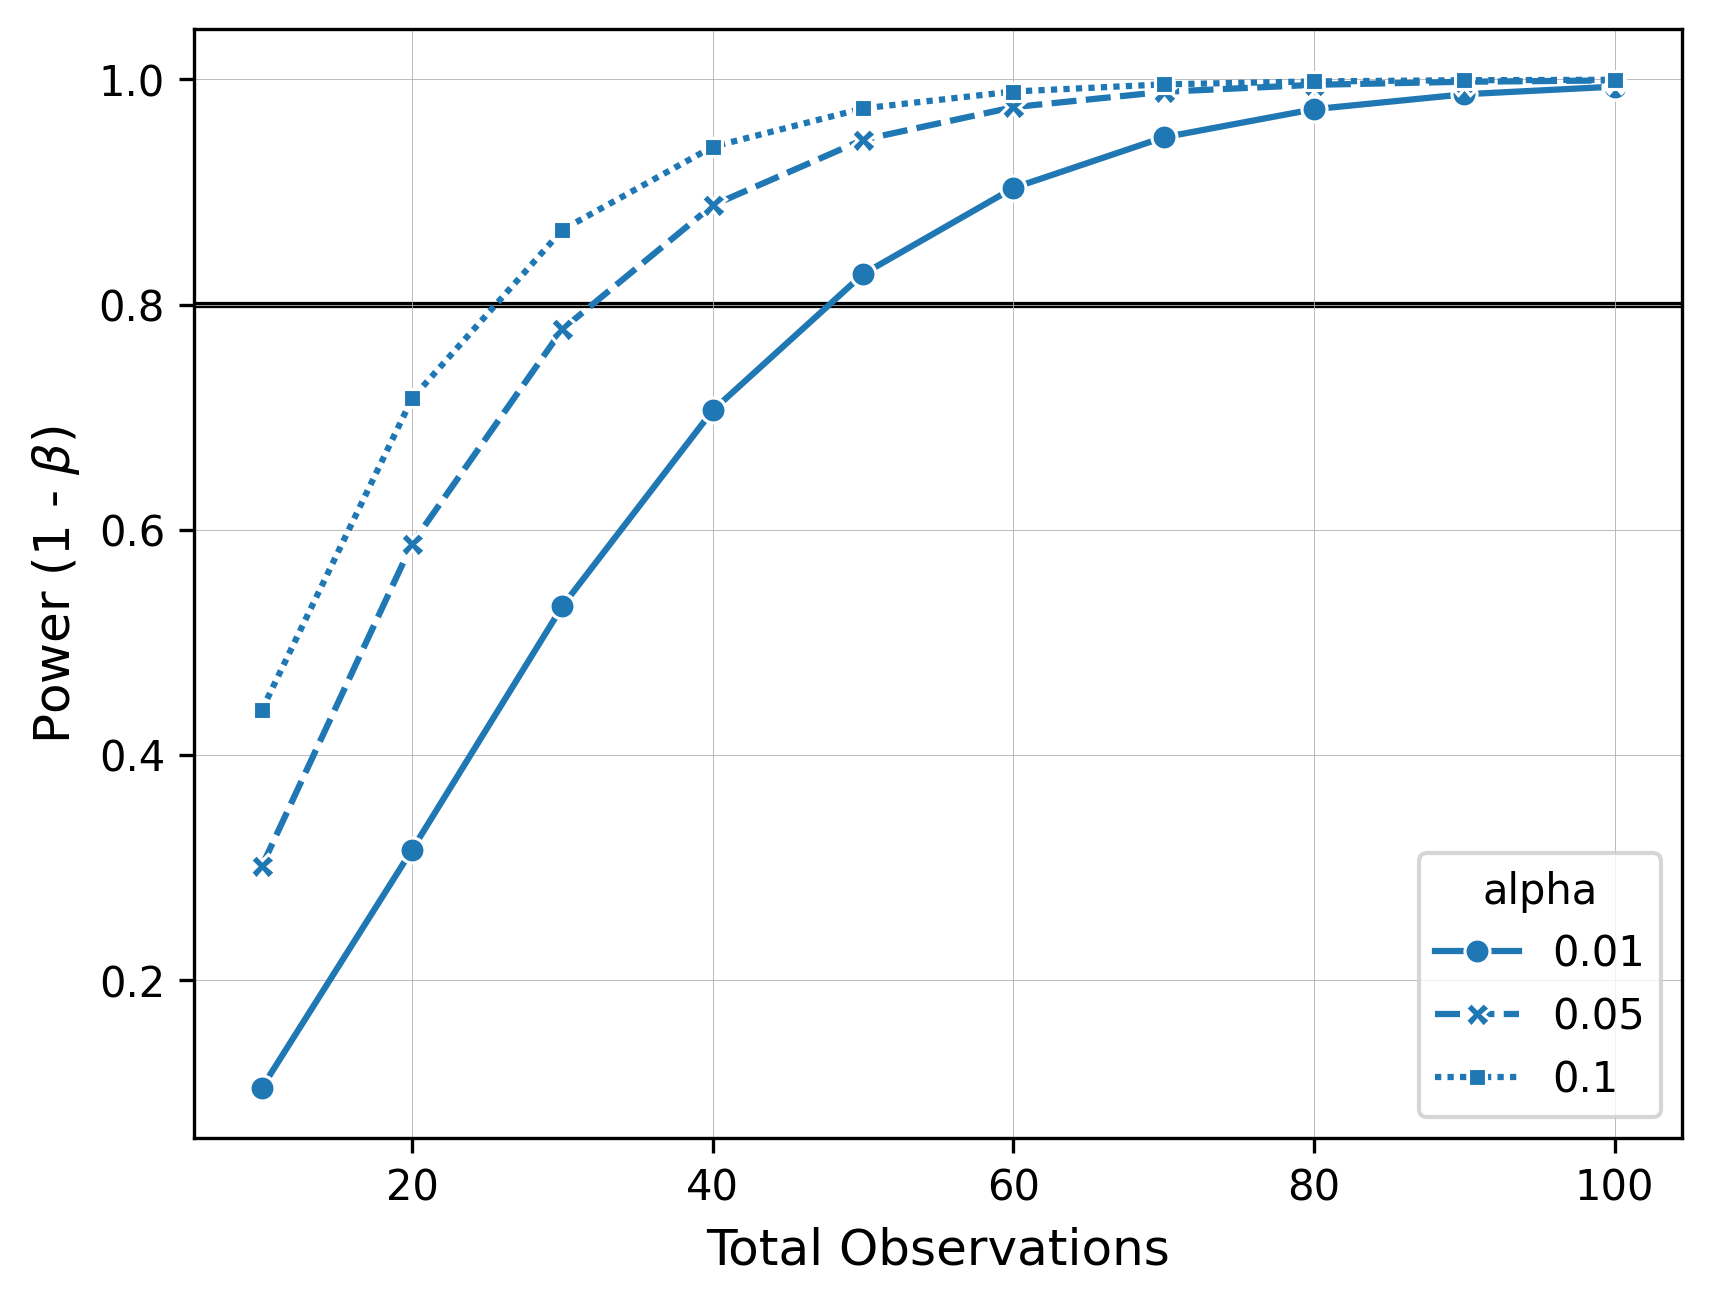

In [59]:
plot_power_curve(results, target_power=0.8, style="alpha", markers=True)
plt.show()

## Step 7. Interpret results



Statistical power increases monotonically with sample size across all significance thresholds.

More stringent α levels require larger cohorts to achieve equivalent power, illustrating the trade-off between false-positive control and sensitivity.

In this example, assuming an effect size of approximately 1.03 and α = 0.05, a total sample size of ~30-40 participants (15–20 per group) is sufficient to achieve 80% power.